In [76]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
# from __future__ import print_function
from keras.utils import to_categorical
import os
from keras.preprocessing.image import ImageDataGenerator, load_img

In [77]:
from keras.applications import VGG16
from keras.models import Model

# vgg_conv = VGG16(weights='imagenet',
#                   include_top=False,
#                   input_shape=(224, 224, 3))

vgg_conv = VGG16(weights='imagenet',
                  include_top=True,
                  input_shape=(224, 224, 3))
vgg_conv = Model(inputs=vgg_conv.input, outputs=vgg_conv.get_layer('fc1').output)


In [78]:
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [79]:
train_dir = r"C:/Users/Hasan/Desktop/code/tutorial_deeplearning/clean-dataset/train" #r for raw string
validation_dir = r"C:/Users/Hasan/Desktop/code/tutorial_deeplearning/clean-dataset/validation"

train_num = 0 # count no. of training data
for r, d, files in os.walk(train_dir):
    train_num +=len(files)
    
validation_num = 0 # count no. of testing data
for r, d, files in os.walk(validation_dir):
    validation_num +=len(files)

In [80]:
from keras.applications import vgg16

datagen = ImageDataGenerator()
batchSize = 32 # 32 is a good starting point
inputSize = 224

train_generator = datagen.flow_from_directory(
    train_dir, 
    target_size = (inputSize,inputSize),  
    batch_size = batchSize,
    class_mode = 'categorical', 
    shuffle = True)

train_features = np.zeros(shape=(train_num, 4096))
train_labels = np.zeros(shape=(train_num,3))

i = 0
for inputs_batch, labels_batch in train_generator:
    inputs_batch = vgg16.preprocess_input(inputs_batch.copy())
    features_batch = vgg_conv.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= train_num:
        break
        
# train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))

Found 600 images belonging to 3 classes.


In [81]:
train_features.shape

(600, 4096)

In [82]:
validation_generator = datagen.flow_from_directory(
    validation_dir, 
    target_size = (inputSize,inputSize), 
    batch_size = batchSize,
    class_mode = 'categorical', 
    shuffle = False)

validation_features = np.zeros(shape=(validation_num, 4096))
validation_labels = np.zeros(shape=(validation_num,3))

i = 0
for inputs_batch, labels_batch in validation_generator:
#     inputs_batch = vgg16.preprocess_input(inputs_batch.copy())
    features_batch = vgg_conv.predict(inputs_batch)
    validation_features[i * batch_size : (i + 1) * batch_size] = features_batch
    validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= validation_num:
        break

Found 150 images belonging to 3 classes.


In [83]:
from keras import models
from keras import layers
 
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4096))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

In [84]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 256)               1048832   
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 771       
Total params: 1,049,603
Trainable params: 1,049,603
Non-trainable params: 0
_________________________________________________________________


In [85]:
from keras import optimizers

model.compile(optimizer=optimizers.SGD(lr=1e-5, decay=1e-6,momentum=0.9,nesterov=True),
             loss = 'categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_features,
                    train_labels,
                    epochs=20,
                    batch_size=batchSize,
                    validation_data=(validation_features,validation_labels))

Train on 600 samples, validate on 150 samples
Epoch 1/20
600/600 [==============================] - 2s 3ms/step - loss: 5.2164 - acc: 0.4683 - val_loss: 3.8599 - val_acc: 0.4667
Epoch 2/20
600/600 [==============================] - 0s 526us/step - loss: 4.0407 - acc: 0.5550 - val_loss: 2.4016 - val_acc: 0.5400
Epoch 3/20
600/600 [==============================] - 0s 525us/step - loss: 2.6390 - acc: 0.6733 - val_loss: 1.7622 - val_acc: 0.5933
Epoch 4/20
600/600 [==============================] - 0s 516us/step - loss: 2.0907 - acc: 0.7283 - val_loss: 1.4392 - val_acc: 0.6467
Epoch 5/20
600/600 [==============================] - 0s 521us/step - loss: 1.4324 - acc: 0.7800 - val_loss: 1.2494 - val_acc: 0.7000
Epoch 6/20
600/600 [==============================] - 0s 525us/step - loss: 1.0797 - acc: 0.8367 - val_loss: 1.1720 - val_acc: 0.7200
Epoch 7/20
600/600 [==============================] - 0s 535us/step - loss: 0.8654 - acc: 0.8550 - val_loss: 1.1177 - val_acc: 0.7200
Epoch 8/20
600/600

In [86]:
test_loss, test_acc = model.evaluate(validation_features,validation_labels)
print(test_loss, test_acc)

150/150 [==============================] - 0s 187us/step
0.9472906282544136 0.8066666642824809


Text(0.5, 1.0, 'Accuracy Curves')

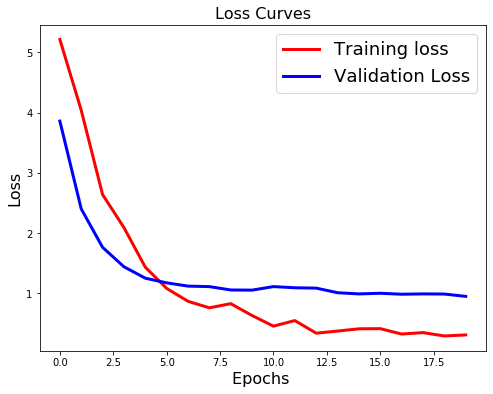

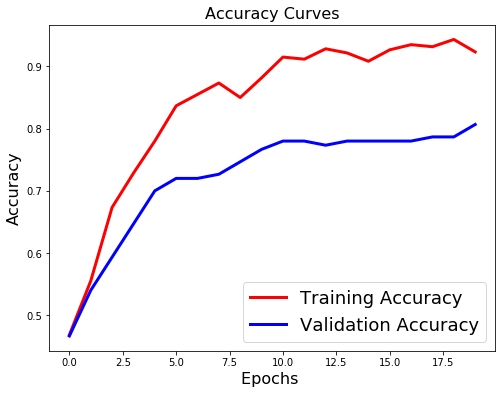

In [87]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [88]:
model.save('transfer_learning.h5')
new_model = tf.keras.models.load_model('transfer_learning.h5')

In [89]:
# import cv2
# # from PIL import Image
# video = cv2.VideoCapture(0)

# while True:

#     __,frame = video.read()
       
#     im = cv2.resize(frame,(30,30))
#     im = im.reshape(30*30*3)
#     im = tf.keras.utils.normalize(im)
# #     img_array = np.array(im)
#     predictions = new_model.predict(im)
#     label = np.argmax(predictions)
    
#     if label == 0: 
#          label = 'pumpkin'
#     elif label == 1: 
#          label = 'tomato'
#     elif label == 2: 
#          label = 'watermelon'
#     # Display the predictions
#     cv2.putText(frame, "Label: {}".format(label), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
#     cv2.imshow("Classification", frame)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#           break

# video.release()
# cv2.destroyAllWindows() 